In [20]:
import nest
import nest.raster_plot
import numpy as np
from utils.inputs import generate_piecewise_constant_signal
import matplotlib.pyplot as plt

In this example, we will compare the network dynamics in the noise- and input-driven regimes. For that purpose, we first drive the network with constant Poissonian input for a period of 1s, followed by patterned stimulation with an inhomogeneous Poisson generator for an additional 1s. 

# Global settings

In [77]:
seed = 1
np.random.seed(seed)

In [78]:
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)

num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 21 15:28:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models.

In [79]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons, number of excitatory synapses per neuron
CI = int(gamma * CE)       # indegree from inhibitory neurons, number of inhibitory synapses per neuron

In [80]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

In [81]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [82]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create excitatory connections
# E synapses
#Heterogenity
alpha_min = 0.1
alpha_max = 1
#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)
syn_dict = {"synapse_model": "excitatory_plastic"}
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# create inhibitory connections
# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)




### Create and connect external inputs
We are going to drive the circuit with noise for an initial period, followed by a patterned stimulus signal.

In [83]:
# external input parameters (background noise)
nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th             # set external rate above threshold
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

In [84]:
print(
    w, 
    nu_ex,
    nu_th,
    p_rate
)

0.316227766016838 0.06324555320336757 0.031622776601683784 6324.555320336757


In [85]:
# external input (stimulus)
step_duration = 50.    # [ms]
scale = p_rate / 2.    # scale input amplitude (max. rate)

sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += sim_time  # stimulus starts after the noise phase

#######
# Ensure inp_times are in the future
kernel_status = nest.GetKernelStatus()
print(kernel_status.keys())  # Print available keys to identify the correct one
current_time = kernel_status['biological_time']  # Adjust this line if 'time' is not the correct key
inp_times = np.array(inp_times)
if np.any(inp_times <= current_time):
    inp_times = inp_times + (current_time - np.min(inp_times)) + 1  # Shift all times to be in the future


dict_keys(['adaptive_target_buffers', 'biological_time', 'buffer_size_spike_data', 'buffer_size_target_data', 'connection_rules', 'data_path', 'data_prefix', 'dict_miss_is_error', 'eprop_learning_window', 'eprop_reset_neurons_on_update', 'eprop_update_interval', 'growth_curves', 'growth_factor_buffer_spike_data', 'growth_factor_buffer_target_data', 'keep_source_table', 'local_num_threads', 'local_spike_counter', 'max_buffer_size_target_data', 'max_delay', 'max_num_syn_models', 'max_update_time', 'min_delay', 'min_update_time', 'modules', 'ms_per_tic', 'network_size', 'node_models', 'num_connections', 'num_processes', 'off_grid_spiking', 'overwrite_files', 'prepared', 'print_time', 'recording_backends', 'recv_buffer_size_secondary_events', 'resolution', 'rng_seed', 'rng_type', 'rng_types', 'send_buffer_size_secondary_events', 'spike_buffer_grow_extra', 'spike_buffer_resize_log', 'spike_buffer_shrink_limit', 'spike_buffer_shrink_spare', 'stimulation_backends', 'structural_plasticity_syna

Text(0.5, 1.0, '$u(t)$')

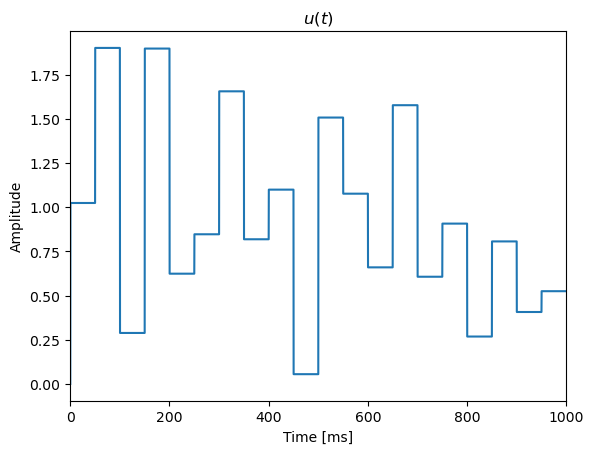

In [86]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [87]:
# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

In [88]:
# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

### Create and connect recording devices
Since we are going to compare the population responses to stimulus versus noise, the simplest way is to record them separately. 

In [89]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_I_noise = nest.Create('spike_recorder')
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

In [90]:
# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(neurons_i, spikes_I_stim)

## Simulate and analyse

In [91]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 21 15:28:35 NodeManager::prepare_nodes [Info]: 
    PreparingMean firing rate: 29.268 Hz (E: 18.868 Hz, I: 39.668 Hz)
 1298 nodes for simulation.

Oct 21 15:28:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1298
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Not using MPI

[  34% ] Model time: 337.0 ms, Real-time factor: 0.1392e: 123.0 ms, Real-time factor: 0.1855

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.1138

Oct 21 15:28:35 SimulationManager::run [Info]: 
    Simulation finished.


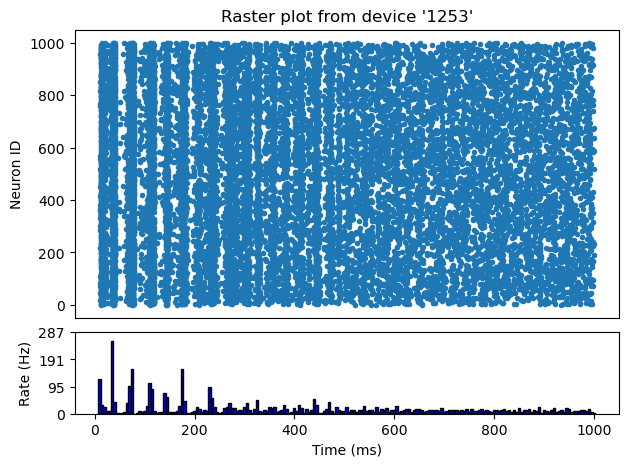

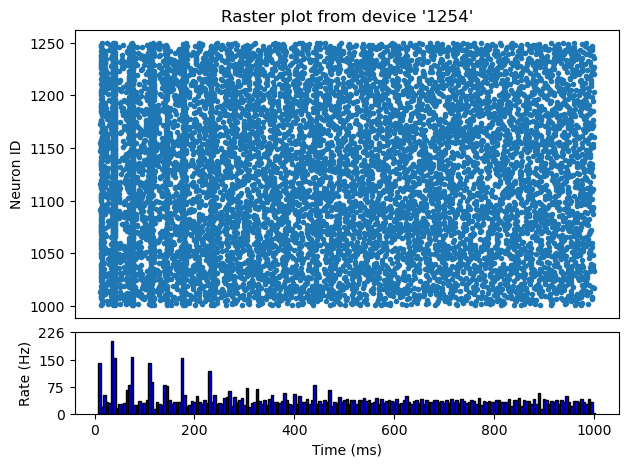

In [92]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

In [37]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 17.866 Hz (E: 17.74 Hz, I: 17.992 Hz)

Oct 21 14:59:56 NodeManager::prepare_nodes [Info]: 
    Preparing 1298 nodes for simulation.

Oct 21 14:59:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1298
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Not using MPI

[  46% ] Model time: 1452.0 ms, Real-time factor: 0.08190972

[ 100% ] Model time: 2000.0 ms, Real-time factor: 0.0759

Oct 21 14:59:56 SimulationManager::run [Info]: 
    Simulation finished.


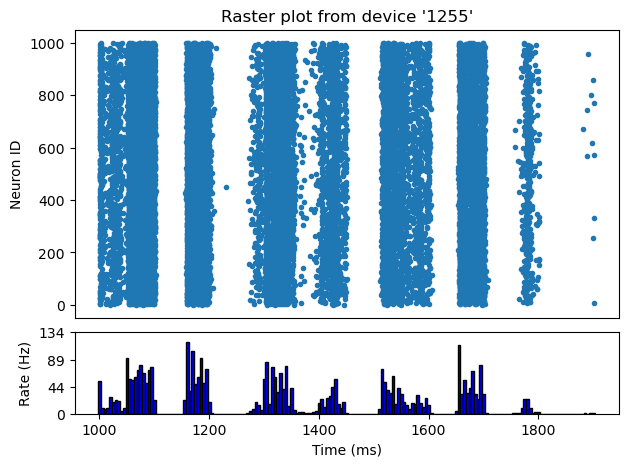

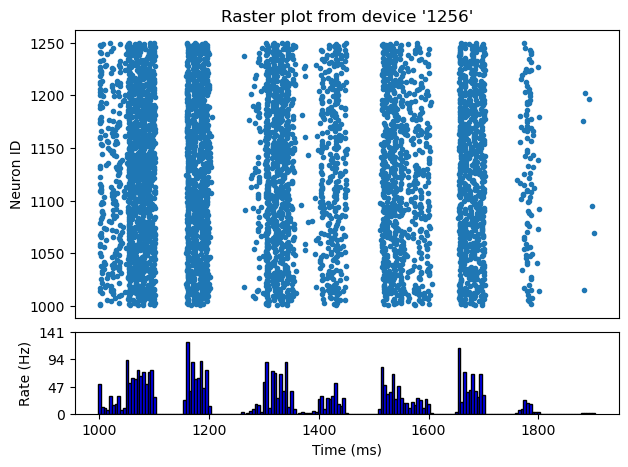

In [38]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
nest.raster_plot.from_device(spikes_I_stim, hist=True)

To explore:

* Characterize the population activity statistics in the two regimes, evaluating the distribution of rates, regularity ($CV_{ISI}$) and synchrony (pairwise correlation coefficient) 
* Change the stimulation parameters to reach a *healthier* dynamic regime in the input-driven condition
* Test different neuron and synapse models